In [1]:
import torch
import torch.nn as nn

import math
from functools import partial
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage import uniform_filter1d
import sys
import time
import cv2

sys.path.append('/home/oscar_palfelt/MSc_thesis/ompl/py-bindings')
from ompl import base as ob
from ompl import control as oc
from ompl import geometric as og

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

In [303]:
# generate random gridMaps

def getRndIntersection():

    # maxIntersectRad = 0.3 # maximum distance (radii) between map center and 

    # # randomly generate center of intersection
    # while True:
    #     x = np.random.uniform()
    #     y = np.random.uniform()

    #     if np.linalg.norm(np.array([x, y]) - np.array([.5, .5])) <= maxIntersectRad:
    #         break

    x = 0.5
    y = 0.5

    alpha1 = np.random.uniform(0, 2*np.pi) # angle of first road

    while True: 
        alpha2 = np.random.uniform(0, 2*np.pi) # angle of second road

        alphaDiff = np.abs((alpha1 - alpha2 + np.pi) % (2 * np.pi) - np.pi)

        if alphaDiff > 0.33*np.pi and alphaDiff < 0.8*np.pi:
            break

    # return center point, line segment angles (center point is common for both lines)
    return np.array([x, y]), alpha1, alpha2

In [3]:
def dist2linesegment(p, a, b): # p: point, a: line end 1, b: line ned 2
    """
    # from https://stackoverflow.com/a/58781995

    Args:
        - p: np.array of single point, shape (2,) or 2D array, shape (x, 2)
        - a: np.array of shape (x, 2)
        - b: np.array of shape (x, 2)
    """

    # normalized tangent vectors
    d_ba = b - a
    d = np.divide(d_ba, (np.hypot(d_ba[:, 0], d_ba[:, 1])
                           .reshape(-1, 1)))

    # signed parallel distance components
    # rowwise dot products of 2D vectors
    s = np.multiply(a - p, d).sum(axis=1)
    t = np.multiply(p - b, d).sum(axis=1)

    # clamped parallel distance
    h = np.maximum.reduce([s, t, np.zeros(len(s))])

    # perpendicular distance component
    # rowwise cross products of 2D vectors  
    d_pa = p - a
    c = d_pa[:, 0] * d[:, 1] - d_pa[:, 1] * d[:, 0]

    return np.hypot(h, c)

In [277]:
def propagateState(traj_x, traj_y, truckState, trailerState, statelist):
    controller = PurePursuitController()

    controller.traj_x = traj_x
    controller.traj_y = traj_y

    delta = controller.compute_control(truckState)

    ctrliter = 0
    while not controller.is_finished and ctrliter < maxCtrlIter:
        
        delta = (delta + controller.compute_control(truckState)) / 2 # helps smoothen steering input
        beta = np.arctan(np.tan(delta) * a12 / (a11 + a12))

        trailerState.x = truckState.x - b1 * np.cos(truckState.yaw) - 1.0 * b2 * np.cos(trailerState.yaw)
        trailerState.y = truckState.y - b1 * np.sin(truckState.yaw) - 1.0 * b2 * np.sin(trailerState.yaw)
        trailerState.yaw += (v * np.sin(truckState.yaw - trailerState.yaw) / (b2 + a21) - v * (b1 - a12) * np.cos(truckState.yaw - trailerState.yaw) * np.sin(beta) / (a12 * (b2 + a21))) * dt

        truckState.x += v * np.cos(truckState.yaw + beta) * dt
        truckState.y += v * np.sin(truckState.yaw + beta) * dt
        truckState.yaw += v * np.sin(beta) / a12 * dt

        statelist.append([truckState.x, truckState.y, truckState.yaw, trailerState.yaw, delta, trailerState.x, trailerState.y]) 

        ctrliter += 1

    if not controller.is_finished:
        raise UserWarning('Exceeded max ctrl iter')

    return statelist

In [308]:
# define planning problem
class MyGoal(ob.Goal):
    def __init__(self, si, goal):
        super(MyGoal, self).__init__(si)
        self.goal = goal

    def isSatisfied(self, state):
        return np.linalg.norm(self.goal - np.array([state[0], state[1], (state[2] + np.pi) % (2 * np.pi) - np.pi])) < 0.03


def getThresholdPathLengthObj(si):
     obj = ob.PathLengthOptimizationObjective(si)
     obj.setCostThreshold(ob.Cost(4.0))
     return obj


def isRV2StateValid(spaceInformation, state):
    # perform collision checking or check if other constraints are
    # satisfied

    p = np.array([state[0], state[1]])

    l1Dist = dist2linesegment(p, a=l1a, b=l1b)
    l2Dist = dist2linesegment(p, a=l2a, b=l2b)

    # print("...")
    # print(np.where((l1Dist <= roadWidth / 2) | (l2Dist <= roadWidth / 2))[0].shape[0])

    if spaceInformation.satisfiesBounds(state):
        return np.where((l1Dist <= roadWidth / 2) | (l2Dist <= roadWidth / 2))[0].shape[0] == 1

def isRV4Valid(spaceInformation, state):
    # perform collision checking or check if other constraints are
    # satisfied

    pTruck = np.array([state[0], state[1]])

    xTrailer = state[0] - b1 * np.cos(state[2]) - np.linspace(0, b2, 6) * np.cos(state[3])
    yTrailer = state[1] - b1 * np.sin(state[2]) - np.linspace(0, b2, 6) * np.sin(state[3])
    pTrailer = np.array([xTrailer, yTrailer]).T

    l1distTruck = dist2linesegment(pTruck, a=l1a, b=l2a)
    l2distTruck = dist2linesegment(pTruck, a=l1b, b=l2b)

    l1distTrailer = dist2linesegment(pTrailer, a=np.tile(l1a, reps=(pTrailer.shape[0], 1)), b=np.tile(l2a, reps=(pTrailer.shape[0], 1)))
    l2distTrailer = dist2linesegment(pTrailer, a=np.tile(l1b, reps=(pTrailer.shape[0], 1)), b=np.tile(l2b, reps=(pTrailer.shape[0], 1)))

    if spaceInformation.satisfiesBounds(state):
        return np.where((l1distTruck <= roadWidth / 2) | (l2distTruck <= roadWidth / 2))[0].shape[0] == 1 and np.where((l1distTrailer <= roadWidth / 2) | (l2distTrailer <= roadWidth / 2))[0].shape[0] == pTrailer.shape[0]


def propagate(start, control, duration, state):
    # global exploredStates
    # exploredStates = np.vstack((exploredStates, np.array([[state.getX(), state.getY(), state.getYaw()]])))

    beta = np.arctan(np.tan(control[0]) * a12 / (a11 + a12))

    state[0] = start[0] + v * np.cos(start[2] + beta) * duration
    state[1] = start[1] + v * np.sin(start[2] + beta) * duration
    state[2] = start[2] + v * np.sin(beta) / a12 * duration
    state[3] = start[3] + (v * np.sin(start[2] - start[3]) / (b2 + a21) - v * (b1 - a12) * np.cos(start[2] - start[3]) * np.sin(beta) / (a12 * (b2 + a21))) * duration


def problemDef(sampleCtrl=False):

    if sampleCtrl:
        # construct the state space we are planning in
        space = ob.RealVectorStateSpace(4)

        # # set the bounds for the R^2 part of SE(2)
        bounds = ob.RealVectorBounds(4)
        bounds.setLow(0, 0.001)
        bounds.setLow(1, 0.001)
        bounds.setLow(2, -2 * np.pi)
        bounds.setLow(3, -2 * np.pi)
        bounds.setHigh(0, 0.999)
        bounds.setHigh(1, 0.999)
        bounds.setHigh(2, 2 * np.pi)
        bounds.setHigh(3, 2 * np.pi)
        space.setBounds(bounds)

        # create a control space
        cspace = oc.RealVectorControlSpace(space, 1)

        # set the bounds for the control space
        cbounds = ob.RealVectorBounds(1)
        cbounds.setLow(-0.65)
        cbounds.setHigh(0.65)
        cspace.setBounds(cbounds)

        ss = oc.SimpleSetup(cspace)
        ss.setStatePropagator(oc.StatePropagatorFn(propagate))
        si = ss.getSpaceInformation()

        si.setPropagationStepSize(.07)
        si.setMinMaxControlDuration(1, 4)
        planner = oc.RRT(si)

        ss.setStateValidityChecker(ob.StateValidityCheckerFn( \
            partial(isRV4Valid, ss.getSpaceInformation())))

    else:
        # construct the state space we are planning in
        space = ob.RealVectorStateSpace(2)

        # set the bounds for the R^2 part of SE(2)
        bounds = ob.RealVectorBounds(2)
        bounds.setLow(0.001)
        bounds.setHigh(0.999)
        space.setBounds(bounds)

        # define a simple setup class
        ss = og.SimpleSetup(space)
        si = ss.getSpaceInformation()
        planner = og.RRTstar(si)

        ss.setStateValidityChecker(ob.StateValidityCheckerFn( \
            partial(isRV2StateValid, ss.getSpaceInformation())))

    ss.setPlanner(planner)
    ss.getProblemDefinition().setOptimizationObjective(getThresholdPathLengthObj(si))
    
    return ss


def plan(planObj, initState, goalState, simplify=False):

    if simplify:    
        space = ob.RealVectorStateSpace(2)

        start = ob.State(space)
        start[0] = initState[0]
        start[1] = initState[1]

        goal = ob.State(space)
        goal[0] = goalState[0]
        goal[1] = goalState[1]

        planObj.setStartAndGoalStates(start, goal, 0.02)

        timeTerminationCondition = ob.timedPlannerTerminationCondition(2.)
    else:
        space = ob.RealVectorStateSpace(4)

        start = ob.State(space)
        start[0] = initState[0] # truck x
        start[1] = initState[1] # truck y
        start[2] = initState[2] # truck yaw
        start[3] = initState[3] # trailer yaw

        si = planObj.getSpaceInformation()
        planObj.setStartState(start)
        planObj.setGoal(MyGoal(si, goalState))

        timeTerminationCondition = ob.timedPlannerTerminationCondition(15.)

    costTerminationCondition = ob.CostConvergenceTerminationCondition(planObj.getProblemDefinition(), solutionsWindow=4, epsilon=1.0)

    solved = planObj.solve(ob.plannerOrTerminationCondition(costTerminationCondition, timeTerminationCondition))

    if simplify and solved:
        planObj.simplifySolution()

In [217]:
class PurePursuitController():

    k = 0.06  # look forward gain
    Lfc = 0.06  # look-ahead distance
    K_p = 1.2  #TODO speed control propotional gain
    K_i = 5.0  #TODO speed control integral gain
    K_d = 0.008  # speed control derivitive gain
    L = 0.0724  # [m] wheel base of vehicle

    def __init__(self):
        self.traj_x = []
        self.traj_y = []
        self.target = None
        self.max_vel = 0.7
        # initialize with 0 velocity
        self.target_velocity = 0.0
        self.last_index = 0
        self.last_d = 100
        self.dt = 0.01
        self.vel_error_int_sum = 0
        self.vel_error = np.array([0])  
        self.vel_error_int = np.array([0]) 
        self.vel_error_der = np.array([0]) 
        self.is_finished = False

    def compute_control(self, state, target=None):
        steering = self.compute_steering(state, target)
        velocity = self.compute_velocity(state)
        return steering

    def compute_steering(self, state, target=None):
        if target is None:
            self.find_target(state)
        else:
            # allow manual setting of target
            self.target = target

        tx, ty = self.target
        alpha = np.arctan2(ty - state.y, tx - state.x) - state.yaw
        if state.v < 0:  # back
            alpha = np.pi - alpha
        Lf = self.k * state.v + self.Lfc
        delta = np.arctan2(2.0 * self.L * 0.5 * np.sin(alpha) / Lf, 1.0)
        return delta
                                   
    def compute_velocity(self, state):
        if self.is_finished:
            # stop moving if trajectory done
            return 0.0
        else:
            # speed control
            # Append the errors to the lists2
            self.vel_error     = np.append(self.vel_error      , self.target_velocity - state.v)
            self.vel_error_int = np.append(self.vel_error_int  , self.vel_error_int[-1] + self.vel_error[-1] * self.dt)
            self.vel_error_der = np.append(self.vel_error_der  , (self.vel_error[-1] - self.vel_error[-2]) / self.dt)

            P = self.vel_error[-1] * self.K_p
            I = self.vel_error_int[-1] * self.K_i
            D = self.vel_error_der[-1] * self.K_d

            correction = P + I + D

            # Saturating the velocity at a max velocity
            return self.target_velocity + min(correction, 0)

    def find_target(self, state):
        ind = self._calc_target_index(state)
        self.last_index = ind
        tx = self.traj_x[ind]
        ty = self.traj_y[ind]
        self.target = (tx, ty)

    def _calc_target_index(self, state):
        # search nearest point index
        dx = [state.x - icx for icx in self.traj_x]
        dy = [state.y - icy for icy in self.traj_y]
        d = [abs(np.sqrt(idx ** 2 + idy ** 2)) for (idx, idy) in zip(dx, dy)]
        ind = d.index(min(d))
        dist = 0.0
        Lf = self.k * state.v + self.Lfc

        # search look ahead target point index
        while Lf > dist and (ind + 1) < len(self.traj_x):
            dx = self.traj_x[ind + 1] - self.traj_x[ind]
            dy = self.traj_y[ind + 1] - self.traj_y[ind]
            dist += np.sqrt(dx ** 2 + dy ** 2)
            ind += 1

        # terminating condition
        if ind >= len(self.traj_x) - 1 and d[-1] < 0.05:
            self.is_finished = True

        return ind


class VehicleState():
    def __init__(self):
        self.x = 0
        self.y = 0
        self.yaw = 0
        self.v = 0

Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 10173 states
Info:    Solution found in 14.999971 seconds
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    ProblemDefinition: Adding approximate solution from planner RRT
Info:    RRT: Created 11477 states
Info:    Solution found in 15.000096 seconds
Info:    RRT: Starting planning with 1 states already in datastructure
Info:    RRT: Created 7974 states
Info:    Solution found in 9.484813 seconds


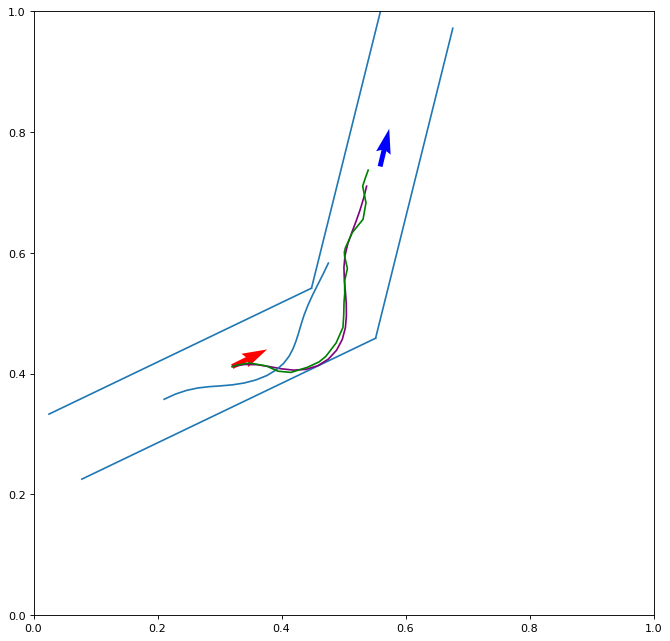

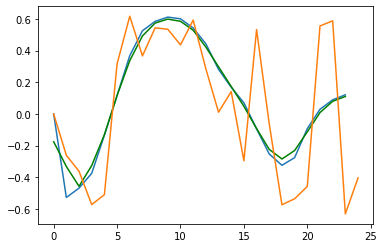

In [315]:
# generate planning scenario, plan, and perform path following

nData = 1
minDistThreshold = 1.1 # minimum distance threshold betwen start/goal
pdef = problemDef(sampleCtrl=False)
pdef_ctrl = problemDef(sampleCtrl=True)
maxCtrlIter = 60
maxInitIter = 1000
roadWidth = 0.12

dt = 0.2 # controller time step
v =  0.1 # vehicle speed
L   = 0.05 # vehicle length constant
Lt  = 0.20 # truck length constant
a11 = 0.5 * L
a12 = L - a11
b1  = 0.9 * a12
b2  = 0.5 * Lt 
a21 = Lt - b2

trajSamples = np.zeros(shape=(1, 7)) # truckX, truckY, truckYaw, trailerYaw, steer trailerX, trailerY
initData = np.zeros(shape=(1, 3)) # x, y, yaw
goalData = np.zeros(shape=(1, 3)) # x, y, yaw
obstacleData = np.zeros(shape=(1, 2)) # the two road angles alpha1, alpha2
data = np.zeros(shape=(1, trajSamples.shape[1] + initData.shape[1] + goalData.shape[1] + obstacleData.shape[1]))

# exploredStates = np.zeros(shape=(1, 3))

plotPaths = True

nPlans = 0
while nPlans < nData:

    c, alpha1, alpha2 = getRndIntersection()

    a = c[0] + 0.5 * np.array([np.cos(alpha1), np.sin(alpha1)]) # line segment 1 end point
    b = c[1] + 0.5 * np.array([np.cos(alpha2), np.sin(alpha2)]) # line segment 2 end point

    l1a = a.reshape(1,2)
    l2a = c.reshape(1,2)
    l1b = b.reshape(1,2)
    l2b = np.copy(l2a)
 
    start = np.array([c[0] + 0.2 * np.cos(alpha1), c[1] + 0.2 * np.sin(alpha1), (alpha1 + np.pi + np.pi) % (2 * np.pi) - np.pi])
    goal  = np.array([c[0] + 0.25 * np.cos(alpha2), c[1] + 0.25 * np.sin(alpha2), (alpha2 + np.pi) % (2 * np.pi) - np.pi])

    truckState = VehicleState()
    truckState.x = start[0]; truckState.y = start[1]; truckState.yaw = start[2]; truckState.v = v

    trailerState = VehicleState()
    trailerState.yaw = truckState.yaw
    trailerState.x = truckState.x - b1 * np.cos(trailerState.yaw) - b2 * np.cos(trailerState.yaw)
    trailerState.y = truckState.y - b1 * np.sin(trailerState.yaw) - b2 * np.sin(trailerState.yaw)

    statelist = [[truckState.x, truckState.y, truckState.yaw, trailerState.yaw, 0, trailerState.x, trailerState.y]]

    pdef_ctrl.clear()
    plan(pdef_ctrl, initState=[truckState.x, truckState.y, truckState.yaw, trailerState.yaw], goalState=goal)
    if not pdef_ctrl.getProblemDefinition().hasExactSolution():
        continue

    csol = np.loadtxt(StringIO(pdef_ctrl.getProblemDefinition().getSolutionPath().printAsMatrix()))
    try:
        statelist = propagateState(traj_x=csol[:,0], traj_y=csol[:,1], truckState=truckState, trailerState=trailerState, statelist=statelist)
    except:
        print("\n \n failed state prop \n \n")
        continue

    nSteps = len(statelist)
    statearr = np.array(statelist).reshape(-1).reshape(nSteps, len(statelist[0]))

    trajSamples = np.vstack((trajSamples, statearr)) # x, y, yaw, yawTrailer, steer
    initData = np.vstack((initData, np.tile(start, reps=(nSteps, 1)))) # x, y, yaw
    goalData = np.vstack((goalData, np.tile(goal, reps=(nSteps, 1))))
    obstacleData = np.vstack((obstacleData, np.tile(np.array([alpha1, alpha2]), reps=(nSteps, 1))))

    if plotPaths:

        sign = np.where(alpha1 < alpha2, 1, -1)
        k = (1 / np.abs(np.sin(.5*(alpha1 - alpha2 + np.pi + np.pi) % (2 * np.pi) - np.pi)))
        
        lcx = c[0] + sign * roadWidth / 2 * np.cos((alpha1 + alpha2)/2) * k
        lcy = c[1] + sign * roadWidth / 2 * np.sin((alpha1 + alpha2)/2) * k
        scx = c[0] - sign * roadWidth / 2 * np.cos((alpha1 + alpha2)/2) * k
        scy = c[1] - sign * roadWidth / 2 * np.sin((alpha1 + alpha2)/2) * k

        plt.figure(figsize=(10,10), dpi=80)

        plt.plot([a[0] + roadWidth / 2 * np.sin(alpha1), scx], [a[1] - roadWidth / 2 * np.cos(alpha1), scy], color='C0')
        plt.plot([a[0] - roadWidth / 2 * np.sin(alpha1), lcx], [a[1] + roadWidth / 2 * np.cos(alpha1), lcy], color='C0')
        plt.plot([b[0] + roadWidth / 2 * np.sin(alpha2), lcx], [b[1] - roadWidth / 2 * np.cos(alpha2), lcy], color='C0')
        plt.plot([b[0] - roadWidth / 2 * np.sin(alpha2), scx], [b[1] + roadWidth / 2 * np.cos(alpha2), scy], color='C0')
        plt.plot(statearr[:,0], statearr[:,1], color='purple')
        plt.plot(statearr[:,5], statearr[:,6], color='C0')
        plt.plot(csol[:,0], csol[:,1], color='green')
        plt.quiver(start[0], start[1], np.cos(start[2]), np.sin(start[2]), color="red", scale=16.0, width=0.008) # init
        plt.quiver(goal[0], goal[1], np.cos(goal[2]), np.sin(goal[2]), color="blue", scale=16.0, width=0.008) # goal
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.show()

        plt.plot(np.arange(statearr.shape[0]), statearr[:, 4])
        plt.plot(np.arange(statearr.shape[0]), uniform_filter1d(statearr[:, 4], size=3, origin=0, mode='nearest', axis=0), color='green')
        plt.plot(np.arange(csol.shape[0]), csol[:,4])
        plt.show()

    if nPlans % 300 == 0: # alleviate stacking of large matrices
        data = np.vstack((data, np.concatenate((trajSamples[1:], initData[1:], goalData[1:], obstacleData[1:]), axis=1))) 

        if nPlans % 900 == 0: # save progress in case of error
            np.savetxt('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/truck_trailer/motion_planning/data/ctrlTrailerIntersection' + str(nPlans), data[1:], delimiter=',', fmt='%1.6f')

        # alleviate stacking of large matrices
        trajSamples = np.zeros(shape=(1, 7))
        initData = np.zeros(shape=(1, 3))
        goalData = np.zeros(shape=(1, 3))
        obstacleData = np.zeros(shape=(1, 2))

    nPlans += 1


In [313]:
print(trajSamples.shape)
print(init)

np.vstack((data, np.concatenate((trajSamples[1:], initData[1:], goalData[1:], obstacleData[1:]), axis=1)))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 25 and the array at index 3 has size 1

In [296]:
print(alpha1)
print(alpha2)
print(np.abs((alpha1 - alpha2 + np.pi) % (2 * np.pi) - np.pi))



4.165722990178638
3.098129512532248
1.0675934776463905


0


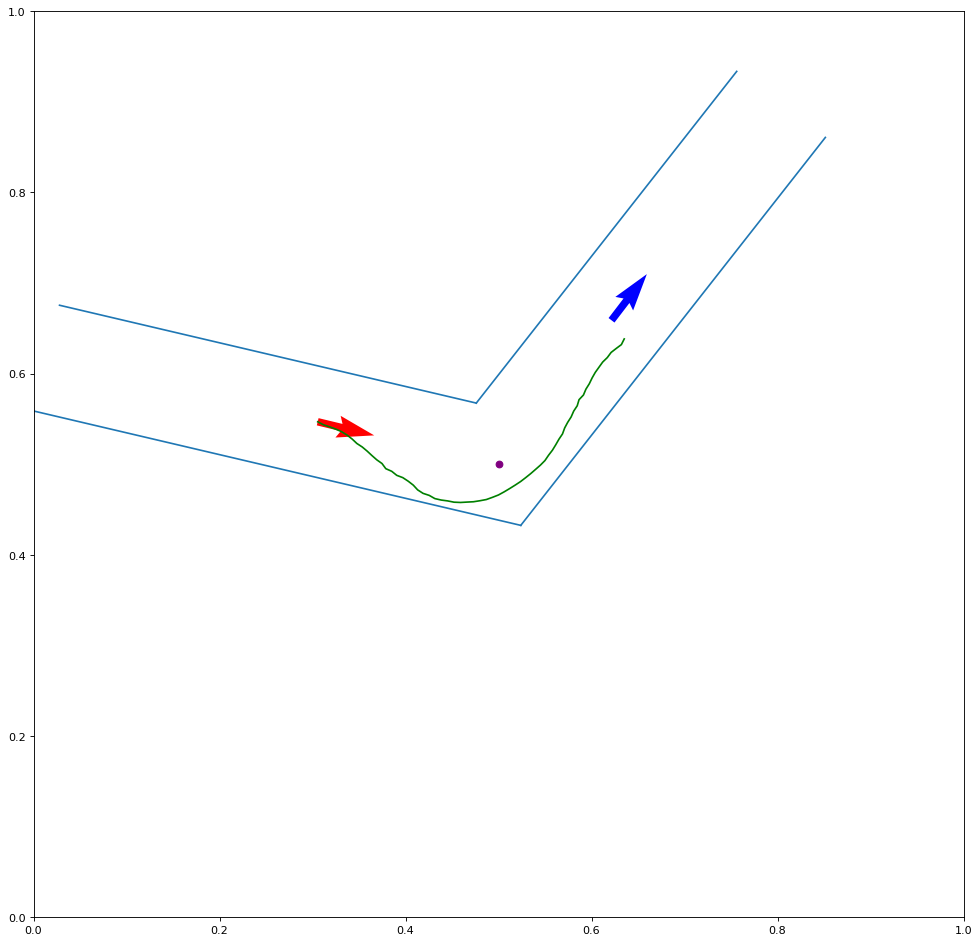

In [219]:
plt.figure(figsize=(15,15), dpi=80)

print(int(alpha1 < alpha2))

sign = np.where(alpha1 < alpha2, 1, -1)
lcx = c[0] + sign * roadWidth / 2 * np.cos((alpha1 + alpha2)/2) * (1 / np.abs(np.sin(.5*(alpha1 - alpha2 + np.pi + np.pi) % (2 * np.pi) - np.pi)))
lcy = c[1] + sign * roadWidth / 2 * np.sin((alpha1 + alpha2)/2) * (1 / np.abs(np.sin(.5*(alpha1 - alpha2 + np.pi + np.pi) % (2 * np.pi) - np.pi)))
scx = c[0] - sign * roadWidth / 2 * np.cos((alpha1 + alpha2)/2) * (1 / np.abs(np.sin(.5*(alpha1 - alpha2 + np.pi + np.pi) % (2 * np.pi) - np.pi)))
scy = c[1] - sign * roadWidth / 2 * np.sin((alpha1 + alpha2)/2) * (1 / np.abs(np.sin(.5*(alpha1 - alpha2 + np.pi + np.pi) % (2 * np.pi) - np.pi)))

plt.plot([a[0] + roadWidth / 2 * np.sin(alpha1), scx], [a[1] - roadWidth / 2 * np.cos(alpha1), scy], color='C0')
plt.plot([a[0] - roadWidth / 2 * np.sin(alpha1), lcx], [a[1] + roadWidth / 2 * np.cos(alpha1), lcy], color='C0')
plt.plot([b[0] + roadWidth / 2 * np.sin(alpha2), lcx], [b[1] - roadWidth / 2 * np.cos(alpha2), lcy], color='C0')
plt.plot([b[0] - roadWidth / 2 * np.sin(alpha2), scx], [b[1] + roadWidth / 2 * np.cos(alpha2), scy], color='C0')

plt.scatter(c[0], c[1], color='purple')
plt.plot(csol[:,0], csol[:,1], color='green')
plt.quiver(start[0], start[1], np.cos(start[2]), np.sin(start[2]), color="red", scale=16.0, width=0.008) # init
plt.quiver(goal[0], goal[1], np.cos(goal[2]), np.sin(goal[2]), color="blue", scale=16.0, width=0.008) # goal
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [10]:
data = np.vstack((data, np.concatenate((trajSamples[1:], initData[1:], goalData[1:], obstacleData[1:]), axis=1)))
np.savetxt('/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/truck_trailer/motion_planning/data/ctrlTrailerIntersection_2000plans', data[1:], delimiter=',', fmt='%1.6f')

In [9]:
print(nPlans)

1976
